In [1]:
# Module import

from __future__ import print_function

from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
#
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u
import time

from scipy import sparse as sps

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# For scaling: 


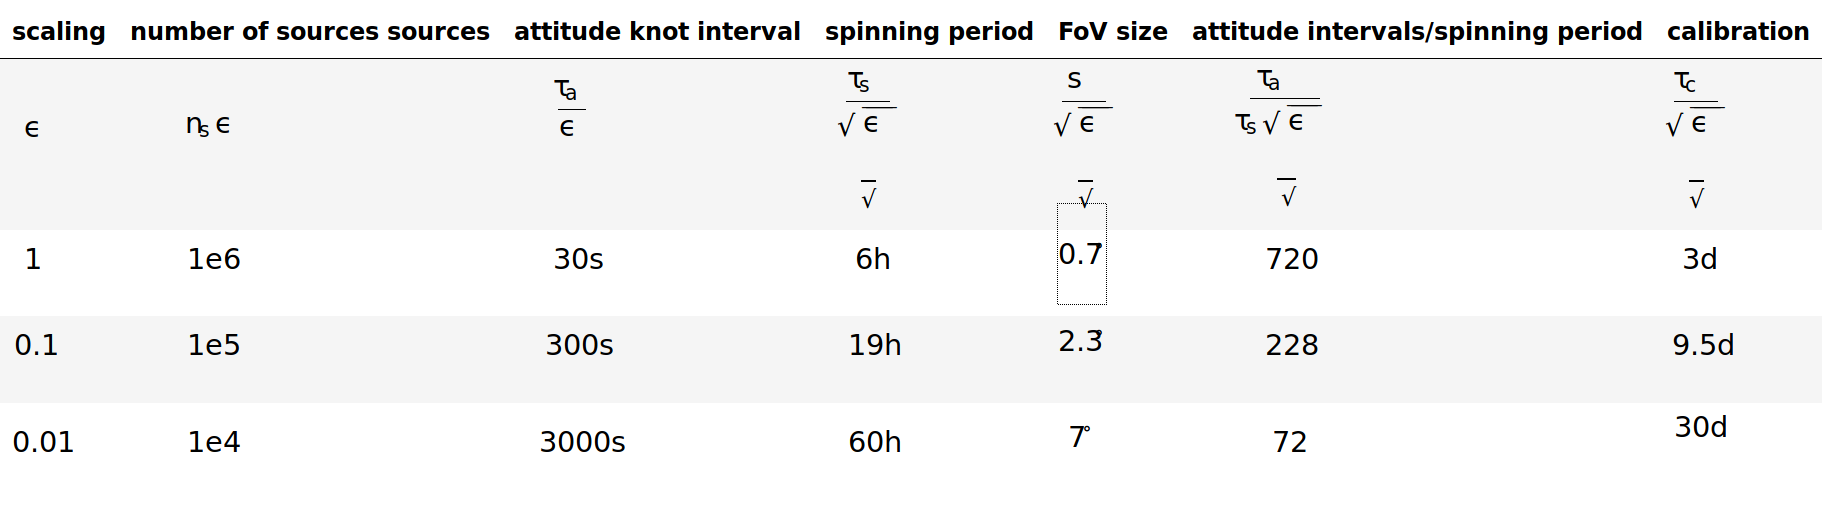

In [2]:
Image('./figures/scaling_factors.png')

# **Initializing objects:**

In [3]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  t_init + 1/2
my_dt = 1/24/10 # [days]

# objects
spline_degree = 3

gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)
print('Sat created')

Sat created


In [25]:
double_telescope = True
my_scanner = Scanner(zeta_limit=np.radians(5) ,double_telescope=double_telescope) 
print('Scanner created')

num_sources=300  # has to be divisible by 3

Scanner created


# End scanner

In [26]:
# Functions usefull for this bit:
times_for_source = np.linspace(t_init, t_end, num=num_sources, endpoint=True)

def generate_angles_of_sources():
    # Warning be carefull to what you use to get alpha/delta from vector
    alphas, deltas = ([], [])
    for t in times_for_source:
        noise = np.random.rand(6) *0
        attitude = gaia.func_attitude(t)
        alpha, delta = generate_observation_wrt_attitude(attitude)
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas += [alpha +noise[0], a_P+noise[1], a_F+noise[2]]
        deltas += [delta +noise[3], d_P+noise[4], d_F+noise[5]]
    return alphas, deltas


In [27]:
def generate_telescope_positions(num_points = 10000):
    # Generate telescopes positions
    alphas_P, deltas_P, alphas_F, deltas_F = ([], [], [], [])
    for t in np.linspace(t_init, t_end, num=num_points):
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas_P.append(a_P-np.pi)
        deltas_P.append(d_P)
        alphas_F.append(a_F-np.pi)
        deltas_F.append(d_F)
    return alphas_P, deltas_P, alphas_F, deltas_F

In [28]:
def transform_twoPi_into_halfPi(deltas):
    deltas = np.array(deltas)
    up_indices = np.where(deltas>np.pi)[0]
    down_indices = np.where(deltas<np.pi)[0]
    deltas[up_indices] -= 2*np.pi
    # deltas[down_indices] += np.pi
    return deltas
    

In [29]:
def add_nans(x,y):
    pos = np.where(np.abs(np.diff(x)) >= 2)[0]+1
    x = np.insert(x, pos, np.nan)
    y = np.insert(y, pos, np.nan)
    """pos = np.where(np.abs(np.diff(y)) >= 1)[0]+1
    x = np.insert(x, pos, np.nan)
    y = np.insert(y, pos, np.nan)"""
    return x, y

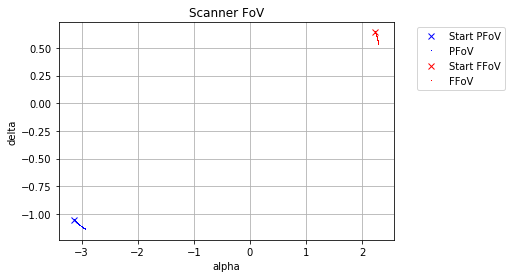

Plotted first plot


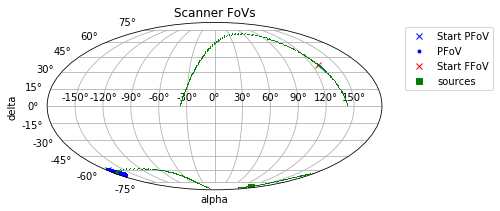

In [30]:
a_min, a_max = (0,100)
alphas, deltas = generate_angles_of_sources()
alphas_P, deltas_P, alphas_F, deltas_F = generate_telescope_positions()

deltas_P = transform_twoPi_into_halfPi(deltas_P)
deltas_F = transform_twoPi_into_halfPi(deltas_F)
fig = plt.figure()
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b,', label='PFoV')
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV')
plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], 'r,', label='FFoV')

"""plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'gs')"""

plt.title("Scanner FoV")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()

print('Plotted first plot')
# ------------------------------ Separation  ----------------------------------------------

fig = plt.figure()
plt.subplot(111, projection="mollweide")
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b.', label='PFoV', alpha=1, linestyle="None", linewidth=0)
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV', linestyle="None")
# plt.scatter(alphas_F[a_min : a_max], deltas_F[a_min : a_max], marker='.')
plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], marker=',')

plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'g,')

plt.title("Scanner FoVs")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()
fig.savefig('./figures/tmp/Mollweide_scanner_positions')

In [31]:
# create soures from that: 
sources = []
for n in range(num_sources):
    sources.append(Source(str(n), np.degrees(alphas[n]), np.degrees(deltas[n]), 10, 10, 10, 10))
    # sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

Sources created


# **Scan**

In [32]:
obs_times = []
calc_sources = []
real_sources = []
for s in sources:
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    print('zetas:', my_scanner.zeta_scanned)
    print('etas:', my_scanner.eta_scanned)
    print('times:', my_scanner.obs_times)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        print('Error: ', my_scanner.scanner_error())
        real_sources.append(s)
        calc_sources.append(Calc_source(obs_times=my_scanner.obs_times.copy(), source=s))
    print('------------------------------------------------------')
sources = real_sources
obs_times = list(np.sort(obs_times))

Starting scan with time from 0 to 0.5 days
Total measured time: 0.02164173126220703
zetas: [-0.0010249531921613538, -0.0043122658210526165, -0.005202722444572749, -0.008346543750535817]
etas: [-2.220446049250313e-16, 1.1102230246251565e-16, -4.440892098500626e-16, -2.220446049250313e-16]
times: [0.036979169653820886, 0.21301940282226603, 0.2869772867857043, 0.46301521050984457]
How many observation time?  4
Error:  -1.942890293094024e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01581120491027832
zetas: [-2.5552101698411714e-08, -0.004425925024668831, -0.016029221933340356, -0.02043131311109965, -0.03197604007564677]
etas: [0.0, 3.3306690738754696e-16, -3.3306690738754696e-16, -1.7763568394002505e-15, -1.1102230246251565e-16]
times: [1.1616269137682063e-09, 0.07395851652754966, 0.24999760769412827, 0.3239562301989001, 0.49999075331220016]
How many observation time?  5
Error:  -3.774758283725532e-16
---------

------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.015293598175048828
zetas: [-0.001898574903984542, -0.009354424127765291, -0.01200088520482527, -0.01933530520311324]
etas: [-1.1102230246251565e-16, 2.220446049250313e-16, -5.551115123125783e-16, 1.1102230246251565e-15]
times: [0.05202936295868653, 0.22806841399843072, 0.3020259974119353, 0.4780601383829742]
How many observation time?  4
Error:  1.6653345369377348e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012502193450927734
zetas: [-2.5565428375616517e-08, -0.004816739116077666, -0.017377119185909642, -0.02219272577987682]
etas: [1.1102230246251565e-16, -3.3306690738754696e-16, 0.0, -7.771561172376096e-16]
times: [0.01505016862382474, 0.08900892696918457, 0.2650499037193096, 0.3390100813440859]
How many observation time?  4
Error:  -2.498001805406602e-16
-------------------------------

zetas: [-0.002559707999039702, -0.013179795012961824, -0.01716405636781571, -0.02770286717400783]
etas: [-3.3306690738754696e-16, 2.220446049250313e-16, -8.881784197001252e-16, 6.661338147750939e-16]
times: [0.06707959776001839, 0.2431187006488657, 0.3170768060937159, 0.493110682442606]
How many observation time?  4
Error:  -8.326672684688674e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.011936187744140625
zetas: [-2.555409598509195e-08, -0.004483408014501856, -0.01627724864342881, -0.0207821527633438]
etas: [0.0, 0.0, 5.551115123125783e-16, 9.992007221626409e-16]
times: [0.030100335888809292, 0.10405931339378496, 0.2801023830484511, 0.35406392598891073]
How many observation time?  4
Error:  3.885780586188048e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.015218257904052734
zetas: [-2.5493675157028942e-08, -0.001204594633502112, -0

Total measured time: 0.014335393905639648
zetas: [-2.5502424616519196e-08, -0.005642378345368078, -0.007524330575225658, -0.013032938249219627]
etas: [-1.1102230246251565e-16, 2.220446049250313e-16, 3.3306690738754696e-16, 3.3306690738754696e-16]
times: [0.045150501966184406, 0.2211907617966519, 0.2951485417309407, 0.47118484994129933]
How many observation time?  4
Error:  1.942890293094024e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.018276453018188477
zetas: [0.0018295387915442552, -0.0029332222078177995, -0.015355727343458572, -0.02010936692944265]
etas: [0.0, 2.220446049250313e-16, -7.771561172376096e-16, -2.220446049250313e-16]
times: [0.00984355120325444, 0.08380211609700892, 0.25984265356889014, 0.3338021693898868]
How many observation time?  4
Error:  -1.942890293094024e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.020666

Total measured time: 0.013178110122680664
zetas: [-2.5472431802731073e-08, -0.0015322244097190866, -0.006343482563034456, -0.007932568238560004]
etas: [2.220446049250313e-16, 1.1102230246251565e-16, -3.3306690738754696e-16, 1.1102230246251565e-15]
times: [0.06354515134160948, 0.1375040946034239, 0.3135480155638211, 0.3875087258698723]
How many observation time?  4
Error:  2.7755575615628914e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012521505355834961
zetas: [-2.5535173753254984e-08, -0.009993903932976991, -0.013712850912621947, -0.02361487999472788]
etas: [0.0, -2.220446049250313e-16, -7.771561172376096e-16, 5.551115123125783e-16]
times: [0.06354515139767226, 0.2395850603979244, 0.31354305997493, 0.4895776006749249]
How many observation time?  4
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01328420

------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013891935348510742
zetas: [-2.5450228396950433e-08, 0.00036605556259334496, 6.796980602656843e-05, 0.00037258286444274876]
etas: [-5.551115123125783e-16, 1.1102230246251565e-16, -3.3306690738754696e-16, -3.3306690738754696e-16]
times: [0.0785953180706012, 0.15255401507694044, 0.3285964599878725, 0.40255514600416137]
How many observation time?  4
Error:  -2.7755575615628914e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013008832931518555
zetas: [0.00462212468746356, -2.555846406737672e-08, -0.012078602063538668, -0.016683773168784978]
etas: [0.0, 0.0, -3.3306690738754696e-16, 1.1102230246251565e-16]
times: [0.0046368803209926, 0.0785953189797413, 0.2546359329551798, 0.3285948673841444]
How many observation time?  4
Error:  -5.551115123125783e-17
---------------------------------------------

times: [0.09531772549351034, 0.1692761346140315, 0.3453169435889451, 0.4192733976100625]
How many observation time?  4
Error:  -3.0531133177191805e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012884855270385742
zetas: [0.004764687516258928, -2.5561529781725774e-08, -0.012448224769698082, -0.017221526152288127]
etas: [1.1102230246251565e-16, 2.220446049250313e-16, 3.3306690738754696e-16, -8.881784197001252e-16]
times: [0.021359424088643567, 0.09531772719626841, 0.2713597233700789, 0.3453200004092883]
How many observation time?  4
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013100862503051758
zetas: [0.0004205641625169496, -0.0015289208347918377, -0.007330833081616816, -0.00933499150601307]
etas: [-2.220446049250313e-16, -3.3306690738754696e-16, -8.881784197001252e-16, 1.3322676295501878e-15]
times: [0.

Error:  -1.3877787807814457e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012173175811767578
zetas: [-2.5482047916192133e-08, 0.0037194884528043114, 0.011421098116446572, 0.015093657426934182]
etas: [0.0, 4.440892098500626e-16, -9.992007221626409e-16, 2.220446049250313e-16]
times: [0.1070234107101005, 0.18098168678909463, 0.3570220391446689, 0.4309775448178036]
How many observation time?  4
Error:  -8.326672684688674e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01229715347290039
zetas: [0.0043346003262487755, -2.554895800477297e-08, -0.011444908517641359, -0.015805292168058215]
etas: [1.1102230246251565e-16, 0.0, -4.440892098500626e-16, -1.887379141862766e-15]
times: [0.03306515960519627, 0.10702341279917346, 0.2830663195822827, 0.35702729195903793]
How many observation time?  4
Error:  -5.551115123125783e-16
--------------------

How many observation time?  4
Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012732267379760742
zetas: [-0.0011543935933945424, 4.564068717252729e-05, 0.0017335884497752167, 0.0028729080827925024]
etas: [-1.1102230246251565e-16, 3.3306690738754696e-16, -1.6653345369377348e-15, -2.220446049250313e-16]
times: [0.08509407860085476, 0.15905299101746181, 0.3350951773589379, 0.409053262529773]
How many observation time?  4
Error:  -4.163336342344337e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012681961059570312
zetas: [-2.5518587631889744e-08, 0.004903826514201874, 0.01544623145634217, 0.020321416667610784]
etas: [0.0, -3.3306690738754696e-16, 2.220446049250313e-16, 4.440892098500626e-16]
times: [0.12207357750450544, 0.1960318151448512, 0.372072795091915, 0.4460282070041655]
How many observation time?  4
Error

Total measured time: 0.012476205825805664
zetas: [0.0009631952592055105, -2.5462642314066922e-08, -0.0034597341495629015, -0.004482211812119171]
etas: [0.0, -3.3306690738754696e-16, 1.1102230246251565e-16, 7.771561172376096e-16]
times: [0.0681818678138385, 0.14214046893157348, 0.31818363457682824, 0.39214350478915827]
How many observation time?  4
Error:  1.3877787807814457e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01261758804321289
zetas: [-0.002404414531047449, 0.0012966867506688411, 0.00895435262894764, 0.012608431484971205]
etas: [-1.1102230246251565e-16, 2.220446049250313e-16, -1.1102230246251565e-15, -2.220446049250313e-16]
times: [0.10683313706512028, 0.18079199631212883, 0.3568330264725538, 0.4307891272857873]
How many observation time?  4
Error:  -3.0531133177191805e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012413

Total measured time: 0.013466119766235352
zetas: [-0.0011758860610547165, -2.5447170200892936e-08, 0.0016303317207938587, 0.002745437529189688]
etas: [-1.1102230246251565e-16, 1.1102230246251565e-16, -1.4432899320127035e-15, -7.771561172376096e-16]
times: [0.08490395414659473, 0.15886287638041735, 0.33490509169768534, 0.4088632099484113]
How many observation time?  4
Error:  -5.551115123125783e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012172698974609375
zetas: [-0.0030469341736293894, 0.0019406992954813065, 0.012684990043593521, 0.01764608424348134]
etas: [3.3306690738754696e-16, 1.1102230246251565e-16, -1.1102230246251565e-16, 6.661338147750939e-16]
times: [0.12355557516877538, 0.19751434677598326, 0.37355582337628496, 0.44751183050007554]
How many observation time?  4
Error:  2.498001805406602e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total me

In [33]:
print('t_end: ', t_end)
if list(np.array(obs_times)[np.where(np.array(obs_times)>t_end)]):
    raise ValueError('observed time greater than end time')

t_end:  0.5


In [34]:
my_scanner.obs_times_FFoV

[0.0915928078170761, 0.34159369263971995]

In [35]:
my_scanner.obs_times_PFoV

[0.16555183934799117, 0.4155511473720398]

# **2- Combine with solver:**

In [36]:
obs_times

[1.1616269137682063e-09,
 0.0012923720447524038,
 0.001482344362425148,
 0.0016722396784856963,
 0.001672241999681126,
 0.0029646260118892783,
 0.00315458617507081,
 0.003344480520579601,
 0.0033444828356259037,
 0.0046368803209926,
 0.004826827577725721,
 0.00501672136458391,
 0.005016723669404389,
 0.0063091346972735446,
 0.00649906870128479,
 0.006688962210425311,
 0.0066889645009629755,
 0.007981389688101949,
 0.008171310027431327,
 0.008361203058028066,
 0.008361205330250839,
 0.00965364487834809,
 0.00984355120325444,
 0.010033443907313554,
 0.010033446157221036,
 0.011325899936090969,
 0.011515792132214722,
 0.011705684758199305,
 0.01170568698183171,
 0.012998154956090241,
 0.013188032883297129,
 0.01337792561060058,
 0.013377927804044433,
 0.014670409691605872,
 0.014860273469967919,
 0.015050166464429944,
 0.01505016862382474,
 0.01634266422564936,
 0.016532513965129,
 0.01672240731959731,
 0.016722409441142456,
 0.01801491821161611,
 0.018204754145583625,
 0.0183946481760104

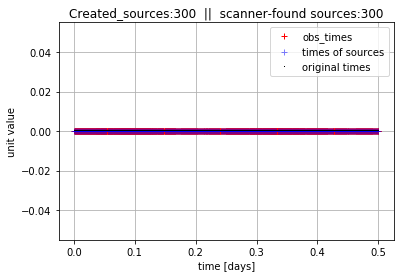

(None, <matplotlib.legend.Legend at 0x7f0c0b607780>, None)

In [37]:
plt.figure()
 
plt.title('Created_sources:'+str(num_sources)+'  ||  scanner-found sources:'+str(len(calc_sources)))

plt.plot(obs_times,np.zeros(len(obs_times)), 'r+', label='obs_times')

plt.plot(times_for_source, np.zeros(len(times_for_source)), 'b+', label='times of sources', alpha=0.5)

sampled_times = np.linspace(t_init, t_end, num=500)
plt.plot(sampled_times, np.zeros(len(sampled_times)), 'k,', label='original times')

plt.xlabel('time [days]'), plt.ylabel('unit value') # , plt.ylim((-1e-6, 1e-6))

plt.grid(), plt.legend(), plt.show()

#bins: 120


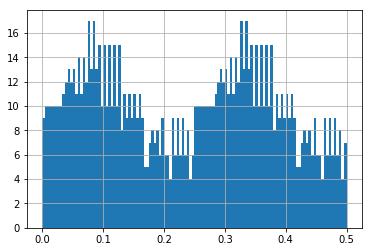

In [38]:
bins = int((t_end-t_init)/my_dt)
print('#bins:', bins)
plt.hist(obs_times, bins=bins, align='mid');
plt.grid();


In [39]:
def noise_calc_sources(s):
    noise = 0.02 / 10
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/100
    s.s_params[3] += s.s_params[3]*0.01
    s.s_params[4] += s.s_params[4]*0.01

In [40]:
print('Updating only sources:')
Solver = Agis(gaia, calc_sources, sources, updating='scanned source', double_telescope=double_telescope)

Updating only sources:


In [41]:
Solver.error_function()

0.0

In [42]:
# Solver.reset_iterations()
#Solver.iterate(1)

# *Update Attitude*

In [43]:
if len(sources) != len(calc_sources):
    raise ValueError('there must be the same number of real and calc sources')

In [61]:
print('Updating attitude')
spline_degree = 3
Solver = Agis(sat=gaia, calc_sources=calc_sources, real_sources=sources, updating='attitude',
              double_telescope=double_telescope,
              attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], 
              spline_degree=spline_degree,
              attitude_regularisation_factor=1e-2)

Updating attitude


In [62]:
# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
my_times = np.array(obs_times)
# Solver.actualise_splines()
print('Error before Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-6
print('c_noise shape: ', c_noise.shape)
last_coef = 4
#Solver.att_coeffs[:last_coef] = Solver.att_coeffs[:last_coef] + c_noise[:last_coef]
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

Error before Noise:  2.227043282775975e-29
c_noise shape:  (4, 121)
Error after Noise:  2.227043282775975e-29


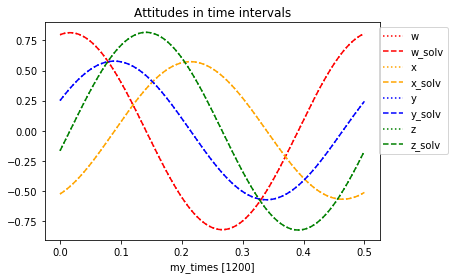

In [63]:
compare_attitudes(gaia, Solver, obs_times)

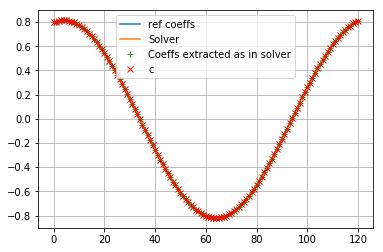

(None, <matplotlib.legend.Legend at 0x7f0c0daa63c8>, None)

In [64]:
to_fit = gaia.s_w
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
a_ref = to_fit.get_coeffs()
plt.plot(a_ref, label='ref coeffs')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.plot(c[0], '+', label='Coeffs extracted as in solver')
plt.plot(Solver.c[0], 'rx', label='c')
plt.grid(), plt.legend(), plt.show()

**Plot matrices:**

In [65]:
if (Solver.att_knots.shape[0] - Solver.att_coeffs.shape[1]) != 4:
    raise ValueError('there should be 4 coeffs less than the number of knots')

In [66]:
N_aa = Solver.compute_attitude_LHS()

N_aa_dim: 121


In [67]:
N_aa_w = N_aa[0::4, 0::4]
N_aa_x = N_aa[1::4, 1::4]
N_aa_y = N_aa[2::4, 2::4]
N_aa_z = N_aa[3::4, 3::4]
N_aa_list = [N_aa_w, N_aa_x, N_aa_y, N_aa_z]
print('N_aa_w.shape', N_aa_w.shape)
print('N_aa_z.shape', N_aa_z.shape)

N_aa_w.shape (121, 121)
N_aa_z.shape (121, 121)


In [68]:
obs_times

[1.1616269137682063e-09,
 0.0012923720447524038,
 0.001482344362425148,
 0.0016722396784856963,
 0.001672241999681126,
 0.0029646260118892783,
 0.00315458617507081,
 0.003344480520579601,
 0.0033444828356259037,
 0.0046368803209926,
 0.004826827577725721,
 0.00501672136458391,
 0.005016723669404389,
 0.0063091346972735446,
 0.00649906870128479,
 0.006688962210425311,
 0.0066889645009629755,
 0.007981389688101949,
 0.008171310027431327,
 0.008361203058028066,
 0.008361205330250839,
 0.00965364487834809,
 0.00984355120325444,
 0.010033443907313554,
 0.010033446157221036,
 0.011325899936090969,
 0.011515792132214722,
 0.011705684758199305,
 0.01170568698183171,
 0.012998154956090241,
 0.013188032883297129,
 0.01337792561060058,
 0.013377927804044433,
 0.014670409691605872,
 0.014860273469967919,
 0.015050166464429944,
 0.01505016862382474,
 0.01634266422564936,
 0.016532513965129,
 0.01672240731959731,
 0.016722409441142456,
 0.01801491821161611,
 0.018204754145583625,
 0.0183946481760104

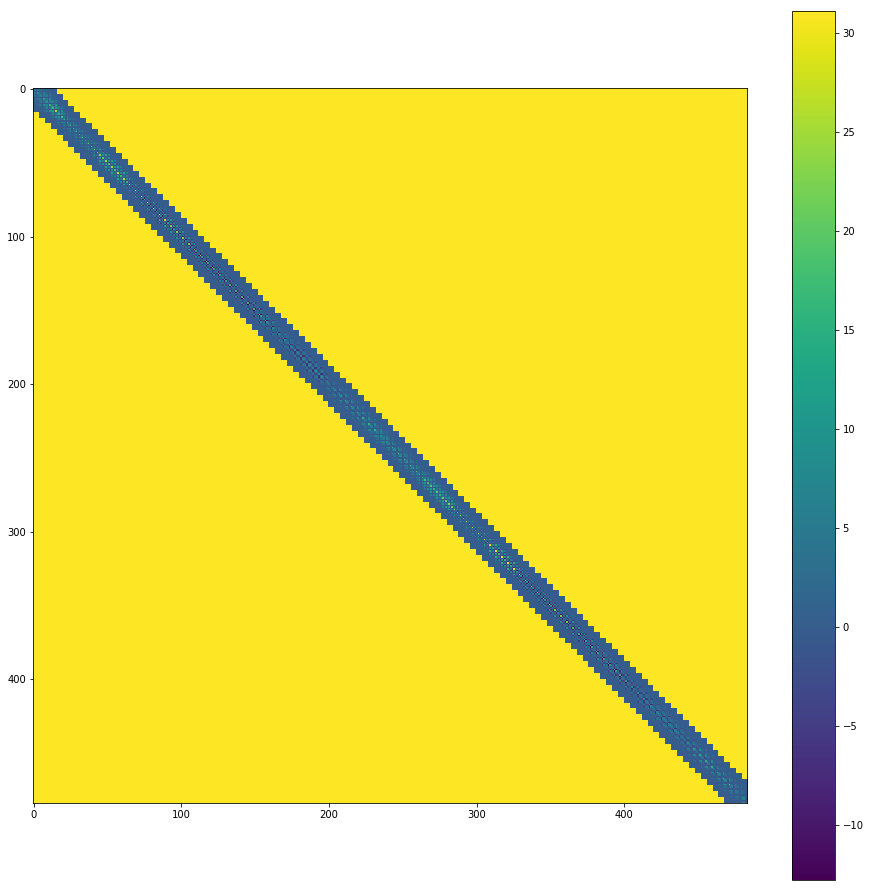

In [69]:
A=N_aa
plt.figure(figsize=(16,16))
threshold = 0
A[np.where(A==threshold)] = A.max()
plt.imshow(A, vmin=None, vmax=None)
plt.colorbar()
#fig.colorbar(plot1, ax=plt)

Text(0.5, 0.98, 'Matrix visualization')

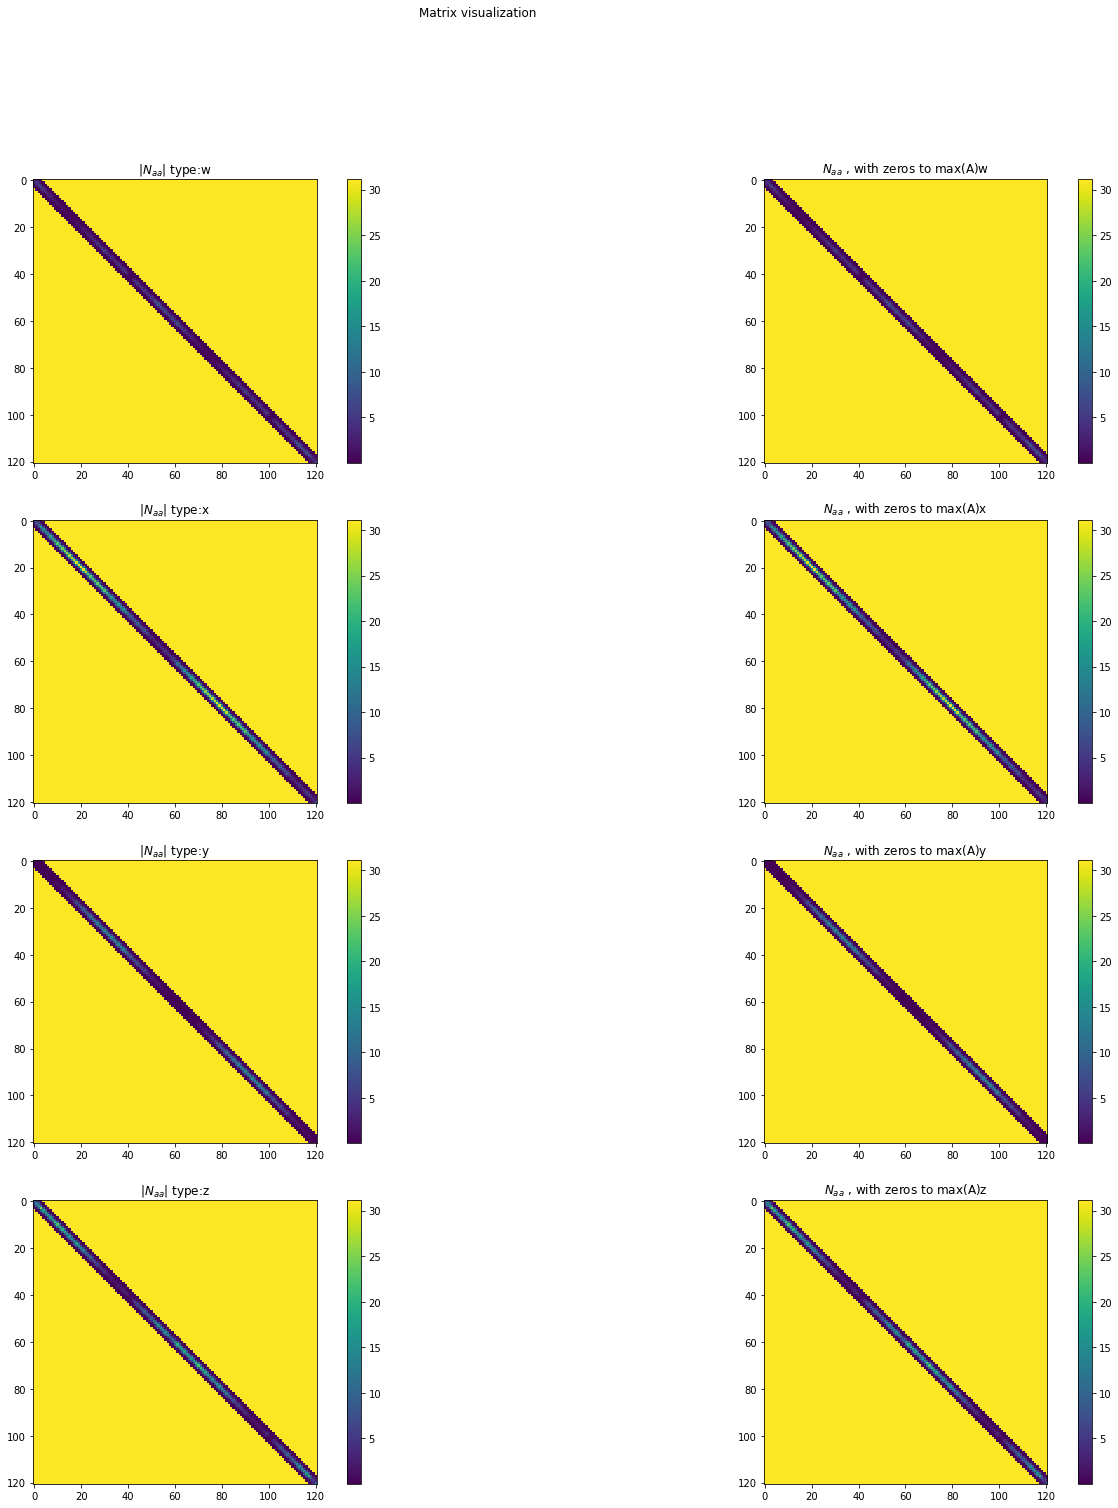

In [70]:
fig, axs = plt.subplots(4, 2, figsize=(24, 24))

type_list = ['w', 'x', 'y', 'z']
for i in range(4):
    A = N_aa_list[i].copy()
    plot1 = axs[i, 0].imshow(np.abs(A), vmin=None, vmax=None)
    axs[i, 0].set_title("$|N_{aa}|$ type:"+type_list[i])
    
    threshold = 0
    A[np.where(A==threshold)] = A.max()
    plot2 = axs[i, 1].imshow(A, vmin=None, vmax=None)
    axs[i, 1].set_title("$N_{aa}$ , with zeros to max(A)"+type_list[i])

    fig.colorbar(plot1, ax=axs[i, 0])
    fig.colorbar(plot2, ax=axs[i, 1])
    
fig.suptitle('Matrix visualization')
# plt.show()

In [71]:
Solver.att_coeffs.shape

(4, 121)

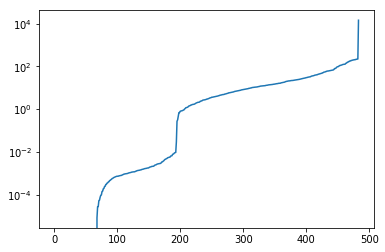

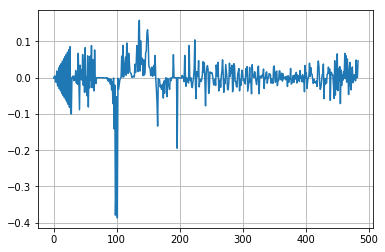

In [72]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
plt.plot(eig_vals, label=type_list[i])
    
plt.yscale('log')
#plt.xlim(0,5)
plt.show()


plt.plot(eig_vecs[0])
#plt.xlim(100,110)
plt.grid()
plt.show()

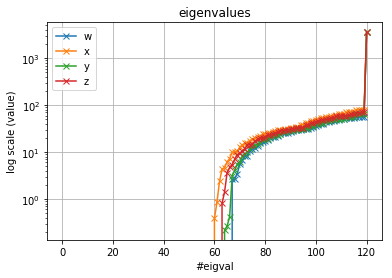

In [77]:
for i, Naa in enumerate(N_aa_list):
    eig_vals, eig_vecs = np.linalg.eigh(Naa)
    plt.plot(eig_vals, label=type_list[i],marker='x')
    if not helpers.check_symmetry(Naa):
        raise ValueError('Matrix not symmetric')
    # print('Condition number: ', np.linalg.cond(Naa))
    # print('Condition number (eig_max/eig_min): ', np.abs(eig_vals.max())/np.abs(eig_vals.min()))
    # print('Rank: ', np.linalg.matrix_rank(Naa, hermitian=True))
    # print('det(N_aa):', np.linalg.det(Naa),'\n')
plt.yscale('log'), plt.legend(), plt.grid()
plt.title('eigenvalues'), plt.ylabel('log scale (value)'), plt.xlabel('#eigval')
# plt.xlim((0,5))

plt.show()

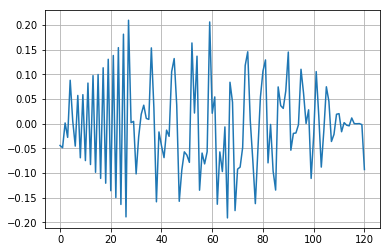

In [78]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa_list[2])
plt.plot(eig_vecs[0])
plt.grid()

# **See iterations**

***** Iteration: 2 *****
N_aa_dim: 121
attitude error: 3.4547949006456596e-05
Error after iteration: 7.992777200134815e-13


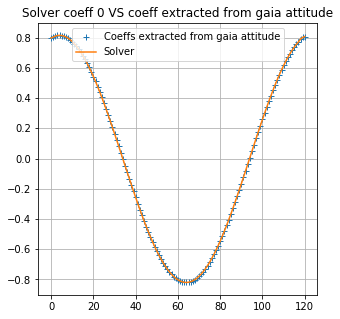

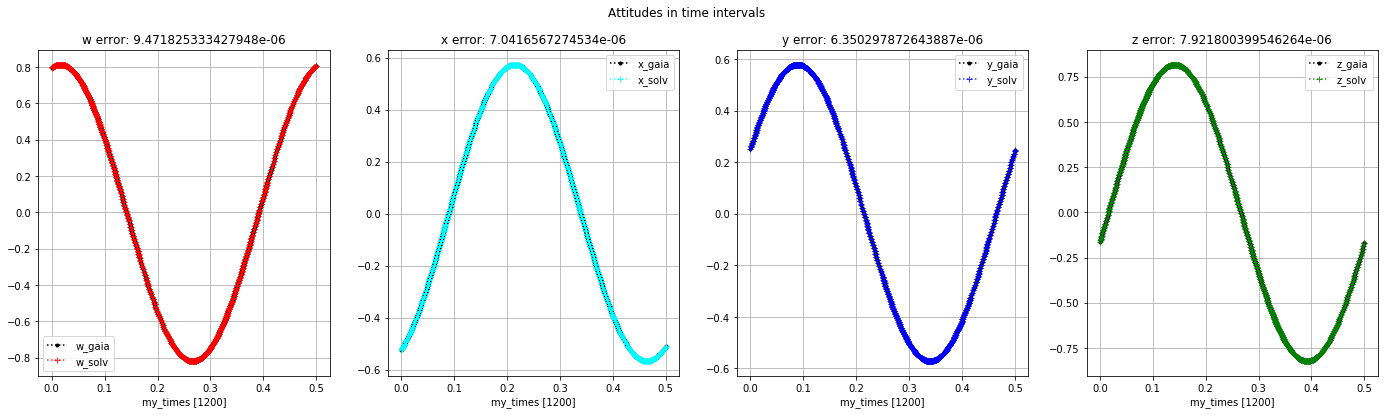

MAGNITUDE: 0.9999999312820536


In [79]:
Solver.verbose=False
# Solver.reset_iterations()
Solver.iterate(1)

plt.figure(figsize=(5,5))
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
plt.plot(c[0], '+', label='Coeffs extracted from gaia attitude')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.title('Solver coeff 0 VS coeff extracted from gaia attitude')
plt.grid(), plt.legend(), plt.show()
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)
print('MAGNITUDE:', Solver.get_attitude(0.005, unit=False).magnitude)
fig2.savefig('lala.png')

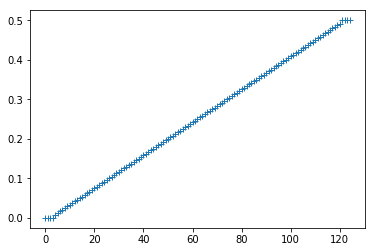

In [80]:
plt.plot(Solver.att_knots, '+')
plt.show()

In [81]:
Solver.iterate(100)

***** Iteration: 3 *****
N_aa_dim: 121


KeyboardInterrupt: 

In [ ]:
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)


In [61]:
B = A.copy()
A = Solver.compute_attitude_LHS()
print((B-A).sum())

N_aa_dim: 25
-2793.8023511538568


In [62]:
hi = h
h = Solver.compute_attitude_RHS()
print((hi-h).sum())

-9.217095069543289e-12
